# Scores & Décisions

In [1]:
########## PARAMETRAGE #########
CT_SAMPLE = True
nSample = 100000
CT_BILAN = False
CT_SAVE = False
CT_CJ = 5
CT_REDUC = True
# Colonnes à ne pas utiliser pour les calculs
dropcols = ['procol', 'msoScore', 'siren', 'indiScore', 'encours', # Correspond à la target, on vire
#            'indiScoreMoins1', 'indiScoreMoins2', 'indiScoreMoins3', 'indiScoreMoins4', # Pour enlever son influence
#            'encoursMoins1', 'encoursMoins2', 'encoursMoins3', 'encoursMoins4', # Pour enlever son influence
#            'procolMoins1', 'procolMoins2', 'procolMoins3', 'procolMoins4' # Pour enlever son influence
           ]
########## PARAMETRAGE #########

In [2]:
# 04/18 Création Morgan SCAO
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from time import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.metrics import roc_curve, auc, mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV

from score_functions import *

In [3]:
# Quelques options d'affichage
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) 
plt.style.use('default')

In [4]:
from sklearn import dummy
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

fpr = []
tpr = []
labels = []
rocs = []

def RunModel(model, label, params={}):
    print (label)
    t0 = time()
    gs = GridSearchCV(model, param_grid=params, cv=5)
    gs.fit(x_train, y_train)

    # On récupère la prédiction de la valeur positive
    y_pred = gs.predict_proba(x_test)[:,1]
    y_pred_Bool = gs.predict(x_test)
    
    false_positive_rate, true_positive_rate, roc_auc = show_confusion_matrix(y_test, y_pred, y_pred_Bool)
    
    fpr.append(false_positive_rate)
    tpr.append(true_positive_rate)
    rocs.append(roc_auc)
    labels.append(label)

    # Save model & infos 
    if CT_SAVE:
        save_sklearn_obj(gs.best_estimator_, 'CJ'+str(CT_CJ)+'_'+label+str(df.shape)+str(int((np.round(roc_auc,3)*1000))))
    
    print("\tDone in %is" % (time() - t0))
    return gs.best_estimator_

In [5]:
def addReel(y_test, y_pred_actuelle):
    #scaler=load_sklearn_obj('scaler')
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_actuelle)

    # Aire sous la courbe
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ("Indiscore actuel")
    print ("\tAUC = %.3f" % roc_auc)

    fpr.append(false_positive_rate)
    tpr.append(true_positive_rate)
    rocs.append(roc_auc)
    labels.append('réel')


In [6]:
# Courbes ROC
def displayROC():
    plt.figure(figsize=(16,10))
    plt.title('Receiver Operating Characteristic')
    colors = ['pink', 'b', 'g', 'r', 'y', 'c', 'm', 'gray', 'aqua', 'lime', 'k']
    for i in range(len(fpr)):
        plt.plot(fpr[i], tpr[i], color=colors[i], label = 'AUC %s = %0.3f' % (labels[i], rocs[i]))
    plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1], linestyle='--')
    plt.axis('tight')
    plt.xlabel('1 - spécificité', fontsize=14)
    plt.ylabel('Sensibilité', fontsize=14)
    plt.show()

## 1. Lecture des tables

*** loadTableCJ ***
reading C:/Users/Mscao/OneDrive - INTESCIA/Export/scores_predictions_PROD_CJ5.csv ...
*** complete_and_clean ***
Suppression des bilans financiers...
reading C:/Users/Mscao/OneDrive - INTESCIA/Export/stats_5_ans_PROD_CJ5.csv ...
2453107 SIREN au total


,siren,ii_DAPET,ii_NBETAB,ii_PROCOL,ii_CAPITAL,ii_EFF_ENT,jl_PARTICIPATION,jl_ACTIONNARIAT,jd_NBPM,jd_NBPP,sb_EnBourse,jg_NBDE,jg_NBDF,bm_NBMARQUES,ii_AGE,indiScore,encours,indiScoreMoins1,encoursMoins1,indiScoreMoins2,encoursMoins2,indiScoreMoins3,encoursMoins3,indiScoreMoins4,encoursMoins4
count,2.453107e+06,2.453107e+06,2.453107e+06,623226.000000,2.453107e+06,2.453107e+06,2.453107e+06,2.453107e+06,2.453107e+06,2.453107e+06,569.0,2.453107e+06,2.453107e+06,2.453107e+06,2.453107e+06,2.453107e+06,2.453107e+06,1.305563e+06,1.305561e+06,702486.000000,702484.000000,476860.000000,476858.000000,374261.000000,374261.000000
mean,6.114417e+08,2.012343e+03,1.851672e-01,0.027743,1.403591e+05,4.740241e+00,1.032605e-01,5.374694e-02,2.078132e-01,1.222939e-06,1.0,6.057828e-02,1.328144e-01,1.367886e-01,5.653482e+00,8.632252e+00,1.323493e+04,8.949066e+00,1.906376e+04,9.626290,28993.686436,9.684618,37128.807435,10.028723,41959.478297
std,1.815512e+08,4.407406e+00,4.985659e-01,0.164235,1.331680e+07,2.011388e+02,3.081236e-01,3.588428e+00,1.411982e+01,1.105865e-03,0.0,3.429932e+00,1.233976e+00,4.419305e+00,3.580806e+00,4.902318e+00,4.573248e+04,4.662256e+00,5.532691e+04,4.724487,69828.943753,4.755019,79626.521907,4.635864,84261.754949
min,5.420021e+06,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,-4.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.529463e+08,2.008000e+03,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,6.000000,644.000000,6.000000,70.000000,7.000000,1150.000000
50%,5.291335e+08,2.013000e+03,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,9.000000e+00,1.550000e+03,9.000000e+00,1.750000e+03,10.000000,5287.000000,10.000000,7977.000000,10.000000,11567.000000
75%,8.103083e+08,2.016000e+03,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,1.200000e+01,7.136000e+03,1.300000e+01,1.150000e+04,13.000000,22848.000000,14.000000,30000.000000,14.000000,32602.000000
max,9.999907e+08,2.066000e+03,1.660000e+02,1.000000,7.441822e+09,2.200000e+05,3.000000e+00,3.720000e+03,7.835000e+03,1.000000e+00,1.0,2.980000e+03,7.940000e+02,3.381000e+03,1.010000e+02,1.900000e+01,5.000000e+05,1.900000e+01,5.000000e+05,19.000000,500000.000000,19.000000,500000.000000,19.000000,500000.000000


,ii_ACTIVNAT,ii_ORIGINE,ii_MODET,ii_EXPLET,ii_CJ,ii_APE_ENT,ii_TEFF_ENT,ii_ADR_DEP,ii_TCA,ii_TCAEXP,ii_NAF1,procol,indiScoreDate,procolMoins1,indiScoreDateMoins1,procolMoins2,indiScoreDateMoins2,procolMoins3,indiScoreDateMoins3,procolMoins4,indiScoreDateMoins4,lastTypeEven,lastTypeEven2
count,2453107,2401741,2453107,465655,2453107,2453107,2453107,2453105,2453107,2453107,2453107,330429,2453107,130165,1305563,76055,702486,39124,476860,23991,374261,2152821,1291492
unique,18,14,1,3,85,723,16,99,11,1,19,9,2704,10,2390,10,2066,8,1782,8,1483,34251,26741
top,0,1,nan,O,5499,7022Z,00,75,nan,nan,G,P,2017-07-28,P,2016-10-25,P,2016-03-03,P,2014-11-04,P,2014-02-03,3200,2315
freq,1311825,1884439,2453107,425241,1135772,108388,1169281,305408,2363855,2453107,526619,143738,92708,88436,13875,43892,9648,31267,6412,18374,5633,1059269,223021


-1258498 sans indiScore il y a 12 mois, ou à 0
-50763 absorptions
Reste 1143846 SIREN




,Entreprises,NAF,NAF niveau 1,Forme juridique,Situation juridique
Quantité,1143846,719,19,83,7


*** showMissingValues ***


,siren,ii_ACTIVNAT,ii_ORIGINE,ii_MODET,ii_EXPLET,ii_CJ,ii_NBETAB,ii_CAPITAL,ii_EFF_ENT,ii_TEFF_ENT,ii_ADR_DEP,ii_TCA,ii_TCAEXP,jl_PARTICIPATION,jl_ACTIONNARIAT,jd_NBPM,jd_NBPP,sb_EnBourse,jg_NBDE,jg_NBDF,bm_NBMARQUES,ii_AGE,ii_NAF1,procol,indiScore,encours,procolMoins1,indiScoreMoins1,encoursMoins1,procolMoins2,indiScoreMoins2,encoursMoins2,procolMoins3,indiScoreMoins3,encoursMoins3,procolMoins4,indiScoreMoins4,encoursMoins4
Type,int64,object,object,object,object,object,int64,int64,int64,object,object,object,object,int64,int64,int64,int64,float64,int64,int64,int64,int64,object,object,int64,int64,object,float64,float64,object,float64,float64,object,float64,float64,object,float64,float64
Valeurs manquantes (nb),0,0,20567,0,1035801,0,0,0,0,0,0,0,0,0,0,0,0,1143372,0,0,0,0,0,1075560,0,0,1119270,0,2,1114528,521143,521145,1129544,727119,727121,1134338,818478,818478
Valeurs manquantes (%),0,0,1.79806,0,90.5542,0,0,0,0,0,0,0,0,0,0,0,0,99.9586,0,0,0,0,0,94.0301,0,0,97.8515,0,0.000174849,97.4369,45.5606,45.5608,98.7497,63.5679,63.5681,99.1688,71.5549,71.5549


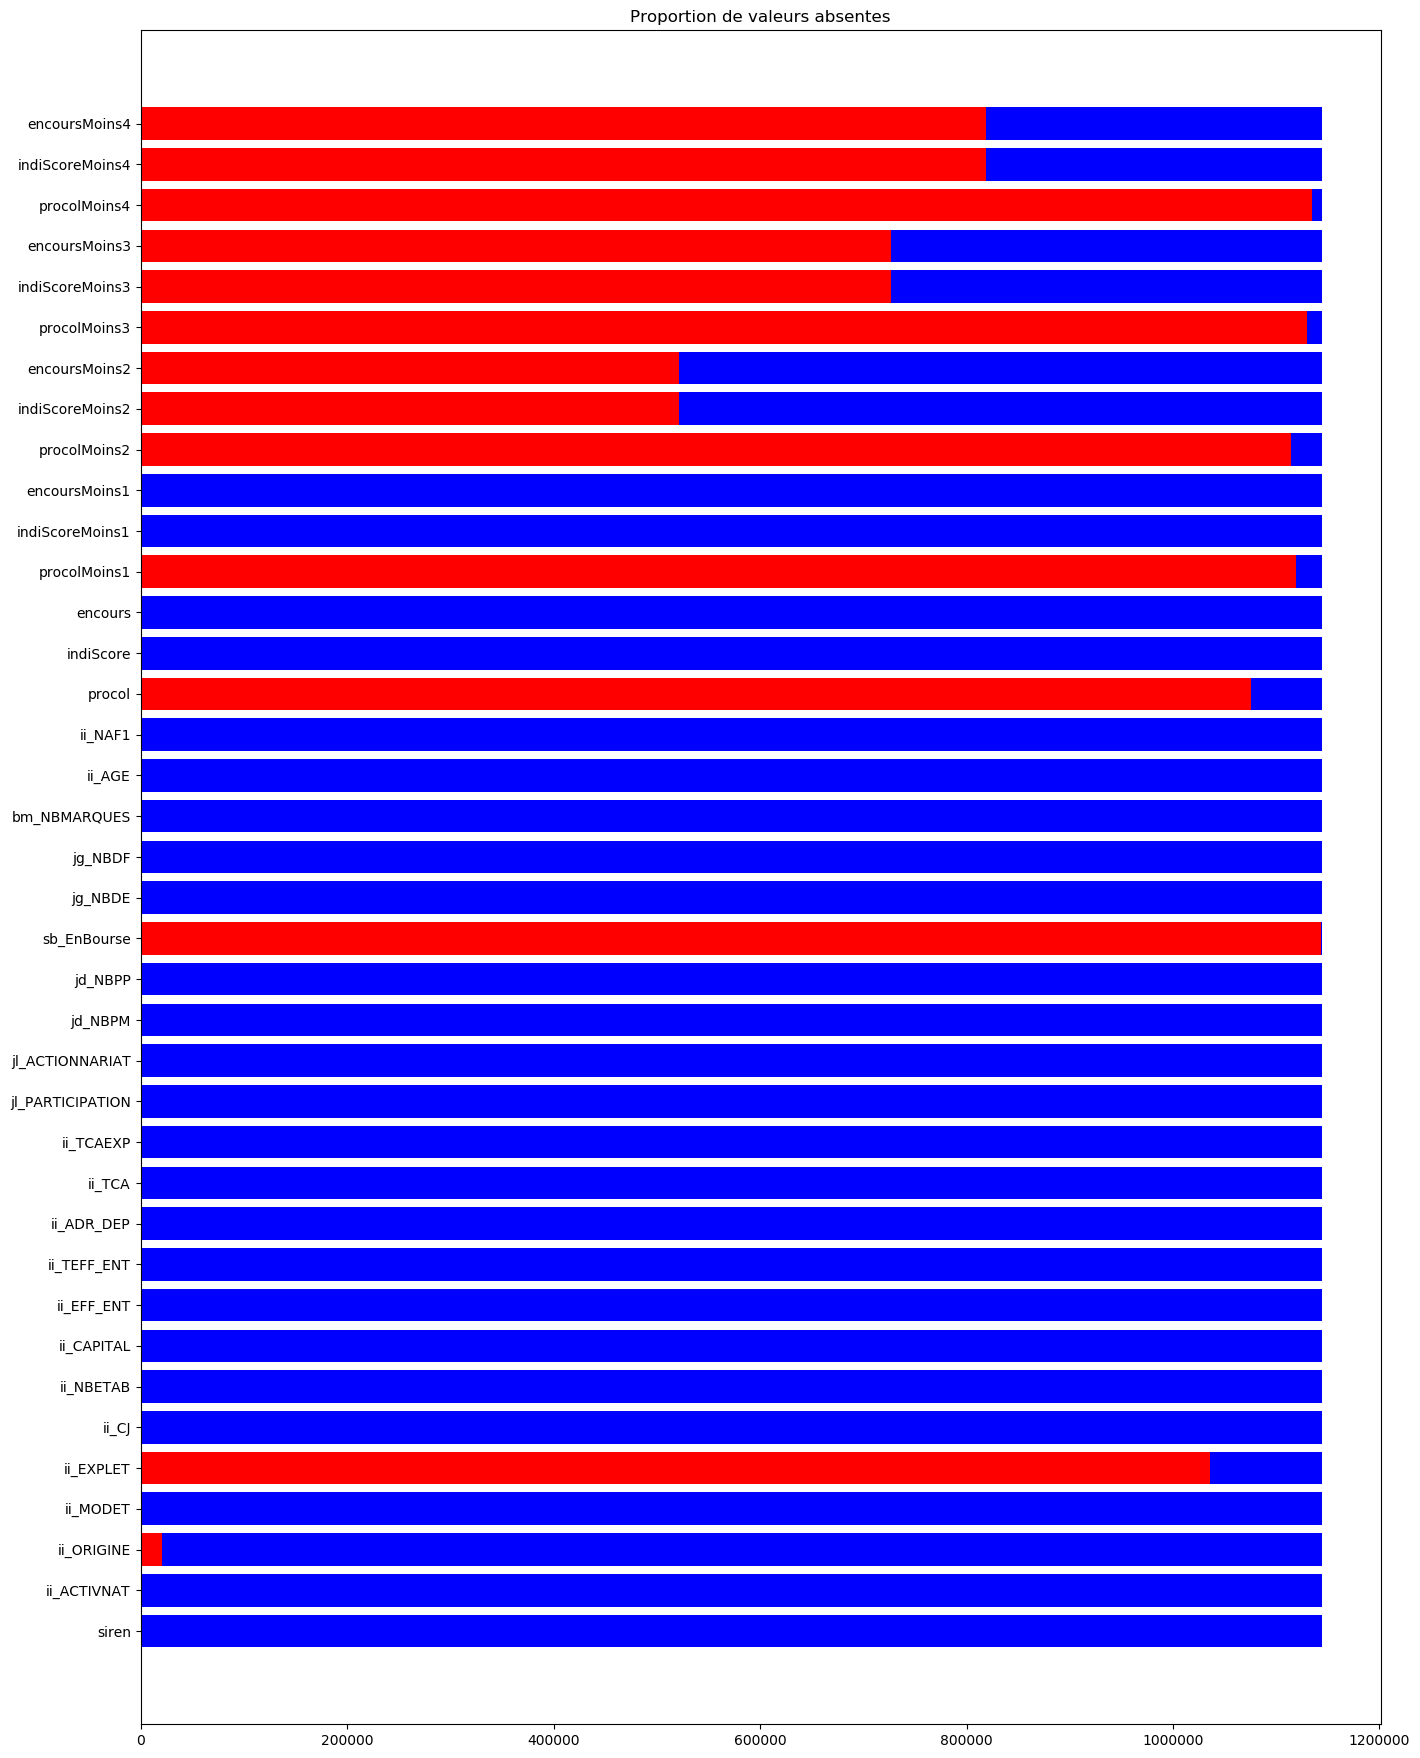

*** fillBlanks ***
	Nan de ii_ORIGINE remplacés par 1
	Nan de ii_EXPLET remplacés par O
	Nan de indiScore remplacés par 9.715781669910111
	Nan de encours remplacés par 21856.486626696253
	Nan de indiScoreMoins1 remplacés par 9.799356731587993
	Nan de encoursMoins1 remplacés par 20405.54998234025
	Nan de indiScoreMoins2 remplacés par 10.300353459032637
	Nan de encoursMoins2 remplacés par 30325.616637840634
	Nan de indiScoreMoins3 remplacés par 10.277438226944739
	Nan de encoursMoins3 remplacés par 38967.65612814206
	Nan de indiScoreMoins4 remplacés par 10.553874382237959
	Nan de encoursMoins4 remplacés par 43863.9438051683
	Nan de ii_ORIGINE remplacés par 0
	Nan de ii_EXPLET remplacés par 0
	Nan de sb_EnBourse remplacés par 0


1075560 SIREN actifs il y a 12 mois
	 837555 TP (True Positifs)
	 238005 FN (False Negatifs)
68286 SIREN en défaut
	 35568 FP (False Positifs)
	 32718 TN (True Negatifs)


In [7]:
dfraw = loadTableCJ(CT_CJ, bBilan=CT_BILAN)
df = dfraw.copy()

In [8]:
if CT_SAMPLE:
    df = dfraw.sample(nSample)

## Préparation des data

In [9]:
x_train, x_test, y_train, y_test, y_pred_actuelle, x_final = prepareData(df, CT_CJ, dropcols, p_strat=df['target'], bSave=CT_SAVE)

Numérique :
	 ['ii_NBETAB', 'ii_CAPITAL', 'ii_EFF_ENT', 'jl_PARTICIPATION', 'jl_ACTIONNARIAT', 'jd_NBPM', 'jd_NBPP', 'sb_EnBourse', 'jg_NBDE', 'jg_NBDF', 'bm_NBMARQUES', 'ii_AGE', 'indiScoreMoins1', 'encoursMoins1', 'indiScoreMoins2', 'encoursMoins2', 'indiScoreMoins3', 'encoursMoins3', 'indiScoreMoins4', 'encoursMoins4']
Catégories :
	 ['ii_ACTIVNAT', 'ii_ORIGINE', 'ii_MODET', 'ii_EXPLET', 'ii_CJ', 'ii_TEFF_ENT', 'ii_ADR_DEP', 'ii_TCA', 'ii_TCAEXP', 'ii_NAF1', 'procolMoins1', 'procolMoins2', 'procolMoins3', 'procolMoins4']
CJ5_column_ii_ACTIVNAT loaded
CJ5_column_ii_ORIGINE loaded
CJ5_column_ii_MODET loaded
CJ5_column_ii_EXPLET loaded
CJ5_column_ii_CJ loaded
CJ5_column_ii_TEFF_ENT loaded


C:\Users\Mscao\Google Drive\Jupyter\GIT\Projet8\score_functions.py:338: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  X[col] = X[col].astype('category', categories=lst)


CJ5_column_ii_ADR_DEP loaded
CJ5_column_ii_TCA loaded
CJ5_column_ii_TCAEXP loaded
CJ5_column_ii_NAF1 loaded
CJ5_column_procolMoins1 loaded
CJ5_column_procolMoins2 loaded
CJ5_column_procolMoins3 loaded
CJ5_column_procolMoins4 loaded
Après binarisation les catégories prennent 302 dimensions.
x_train : (80000, 322)


		Analyse de toutes les données
Matrice de confusion
	AUC = 0.629
	Spécificité = 0.479
	Precision = 0.959
	Recall = 0.779


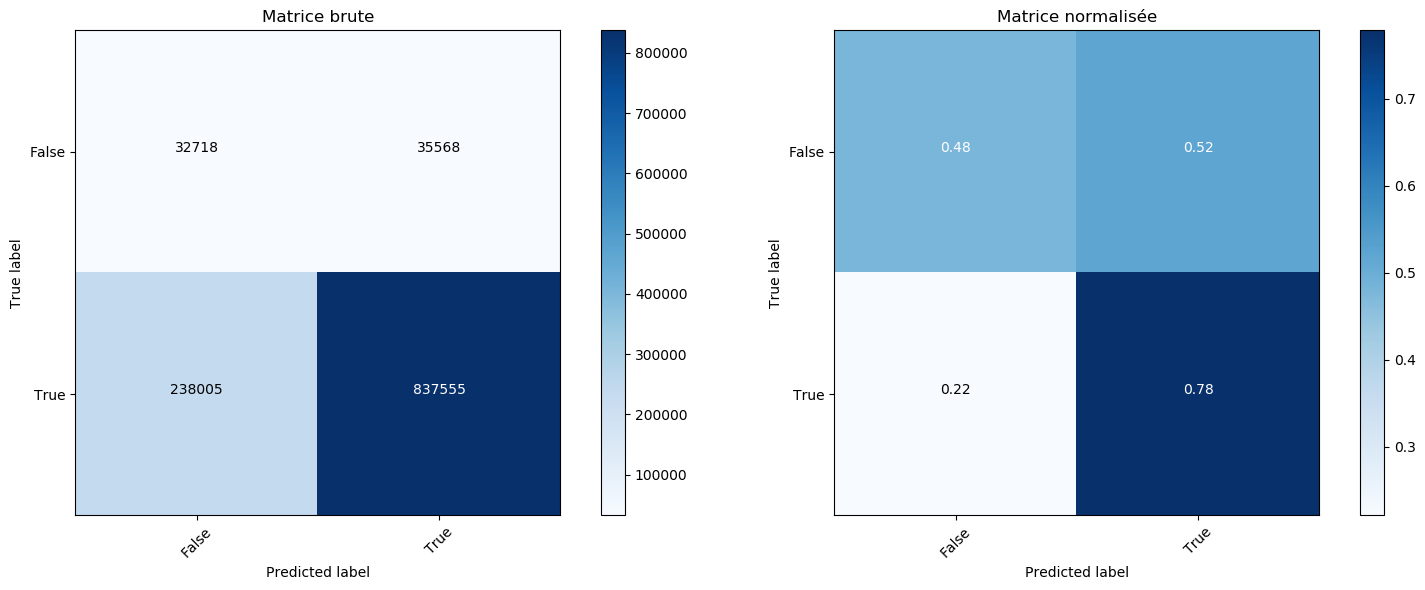

(array([0.  , 0.52, 1.  ]), array([0.  , 0.78, 1.  ]), 0.6289235801906446)

In [10]:
print('\t\tAnalyse de toutes les données')
# Compute confusion matrix - TOUTE LES DONNEES
show_confusion_matrix(df['target'], (df.indiScoreMoins1>6))

		Analyse du jeu de test
Matrice de confusion
	AUC = 0.628
	Spécificité = 0.478
	Precision = 0.959
	Recall = 0.779


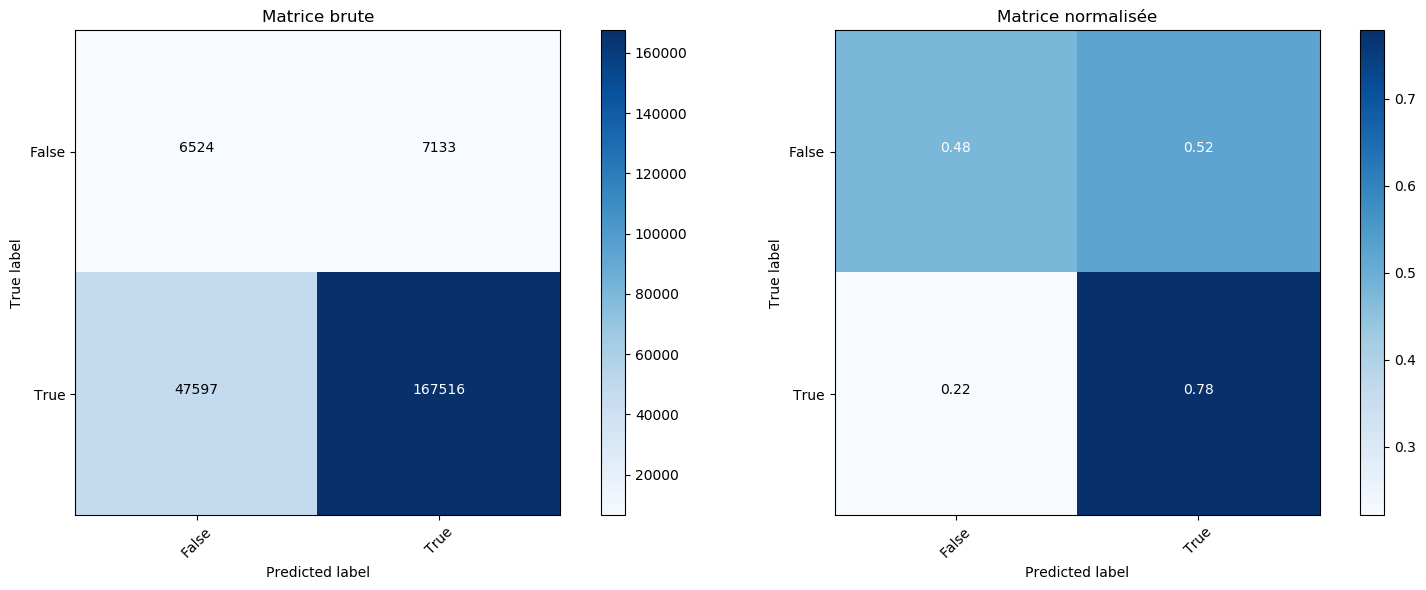

(array([0.  , 0.52, 1.  ]), array([0.  , 0.78, 1.  ]), 0.6282193195717146)

In [11]:
print('\t\tAnalyse du jeu de test')
# Compute confusion matrix - JEU DE TEST
show_confusion_matrix(y_test, y_pred_actuelle)

In [11]:
# Réduction
if CT_REDUC:
    reducPCA, X_red = testPCA(pd.merge(x_test, x_train))
    x_train = reducPCA.transform(x_train)
    x_test = reducPCA.transform(x_test)

Nombre de dimensions original : 322
PCA, nombre de dimensions pour 90% d'explication : 11


RandomForestClassifier
Matrice de confusion
	AUC = 0.816
	Spécificité = 0.312
	Precision = 0.958
	Recall = 0.996


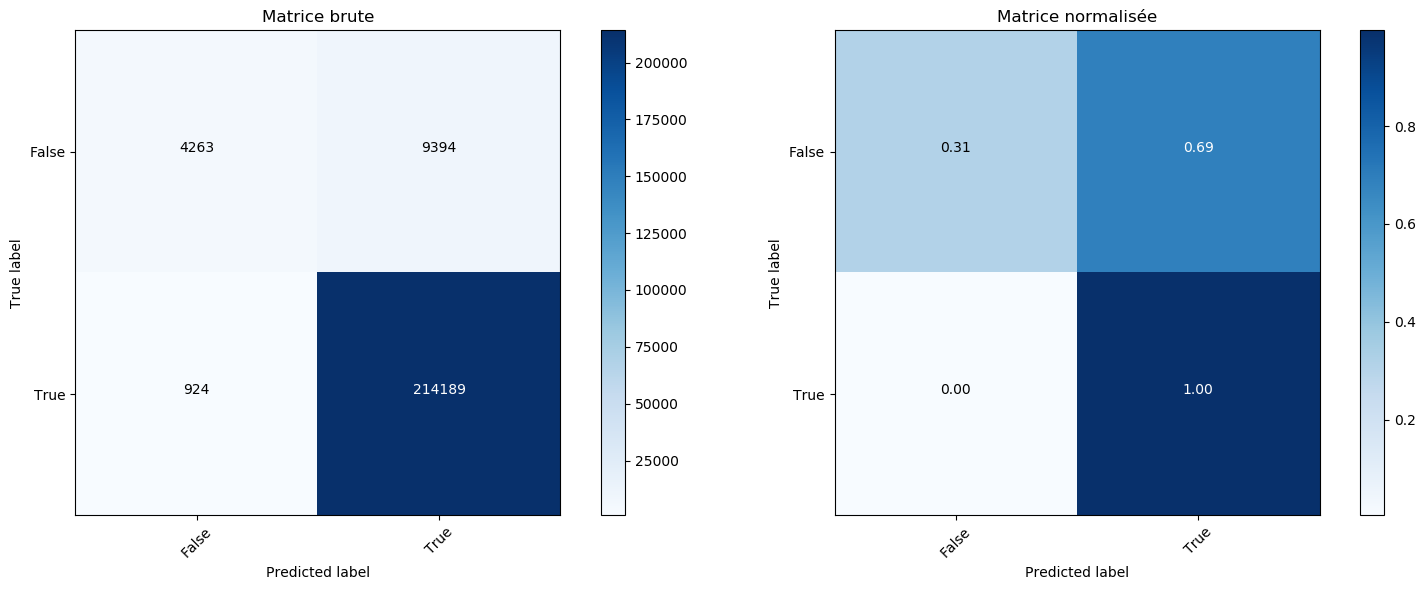

C:/Users/Mscao/Google Drive/Jupyter/GIT/Projet8/save/CJ5_RandomForestClassifier(1143846, 39)816.pkl saved
	Done in 3901s
LogisticRegression
Matrice de confusion
	AUC = 0.820
	Spécificité = 0.285
	Precision = 0.956
	Recall = 0.997


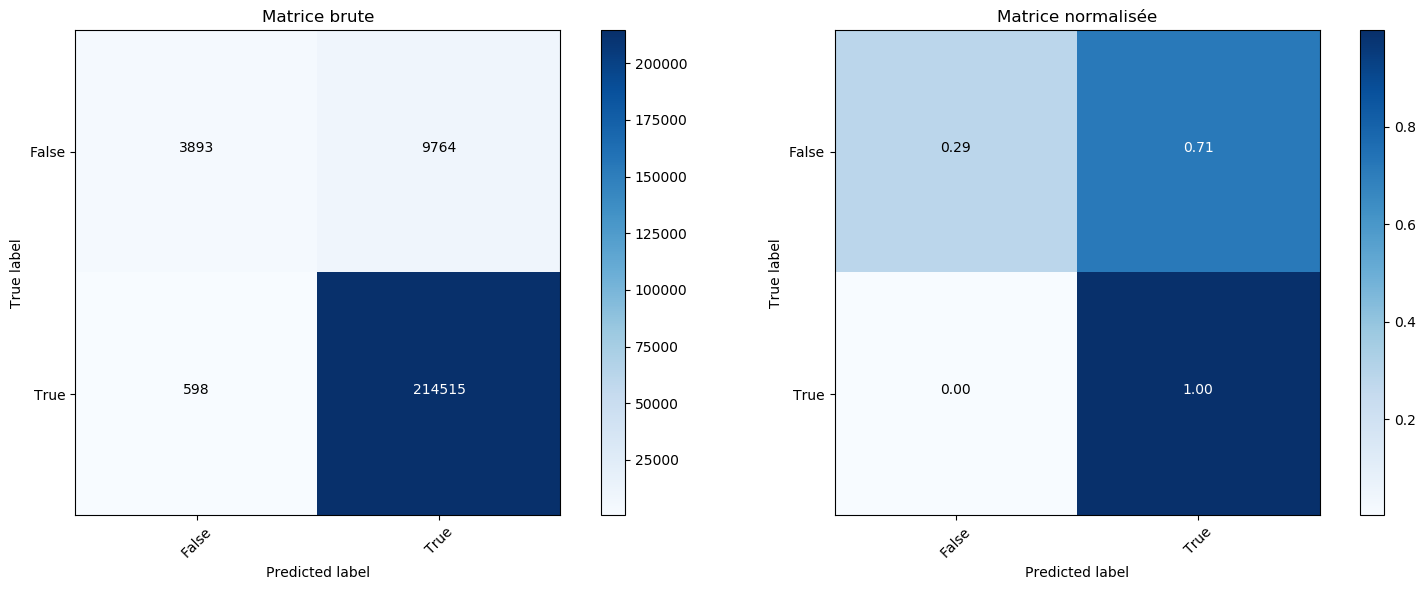

C:/Users/Mscao/Google Drive/Jupyter/GIT/Projet8/save/CJ5_LogisticRegression(1143846, 39)820.pkl saved
	Done in 53237s
ExtraTreesClassifier
Matrice de confusion
	AUC = 0.740
	Spécificité = 0.334
	Precision = 0.959
	Recall = 0.985


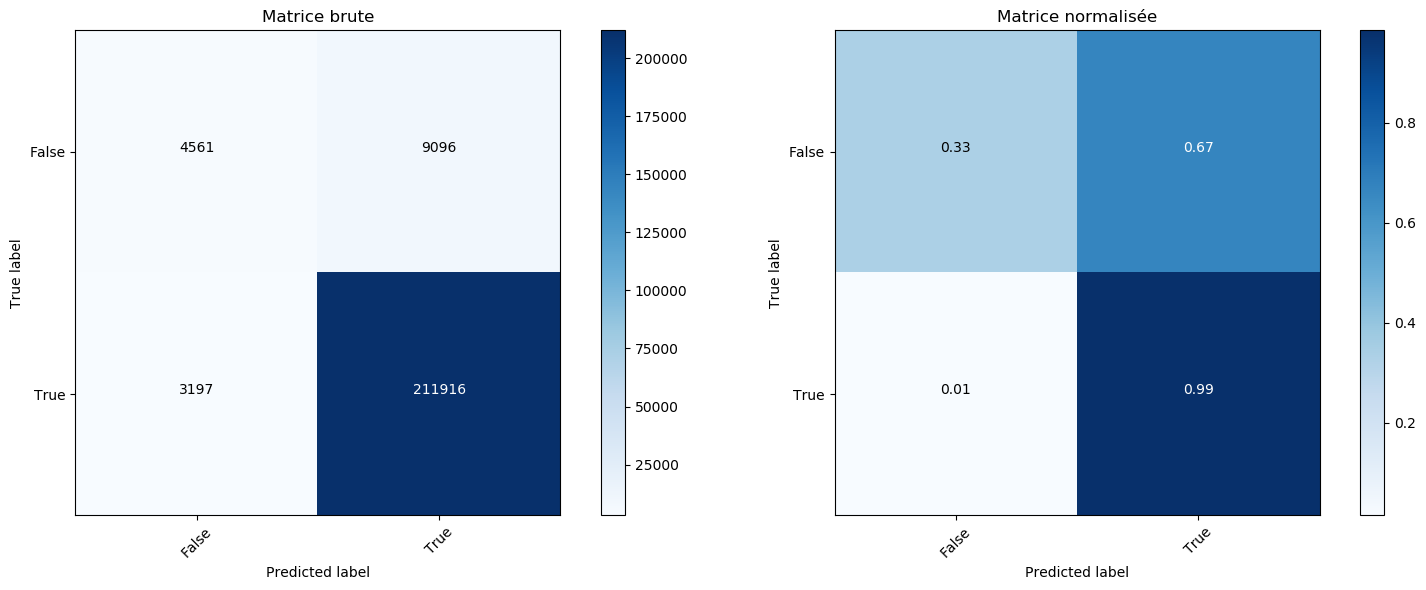

C:/Users/Mscao/Google Drive/Jupyter/GIT/Projet8/save/CJ5_ExtraTreesClassifier(1143846, 39)740.pkl saved
	Done in 660s
Indiscore actuel
	AUC = 0.628


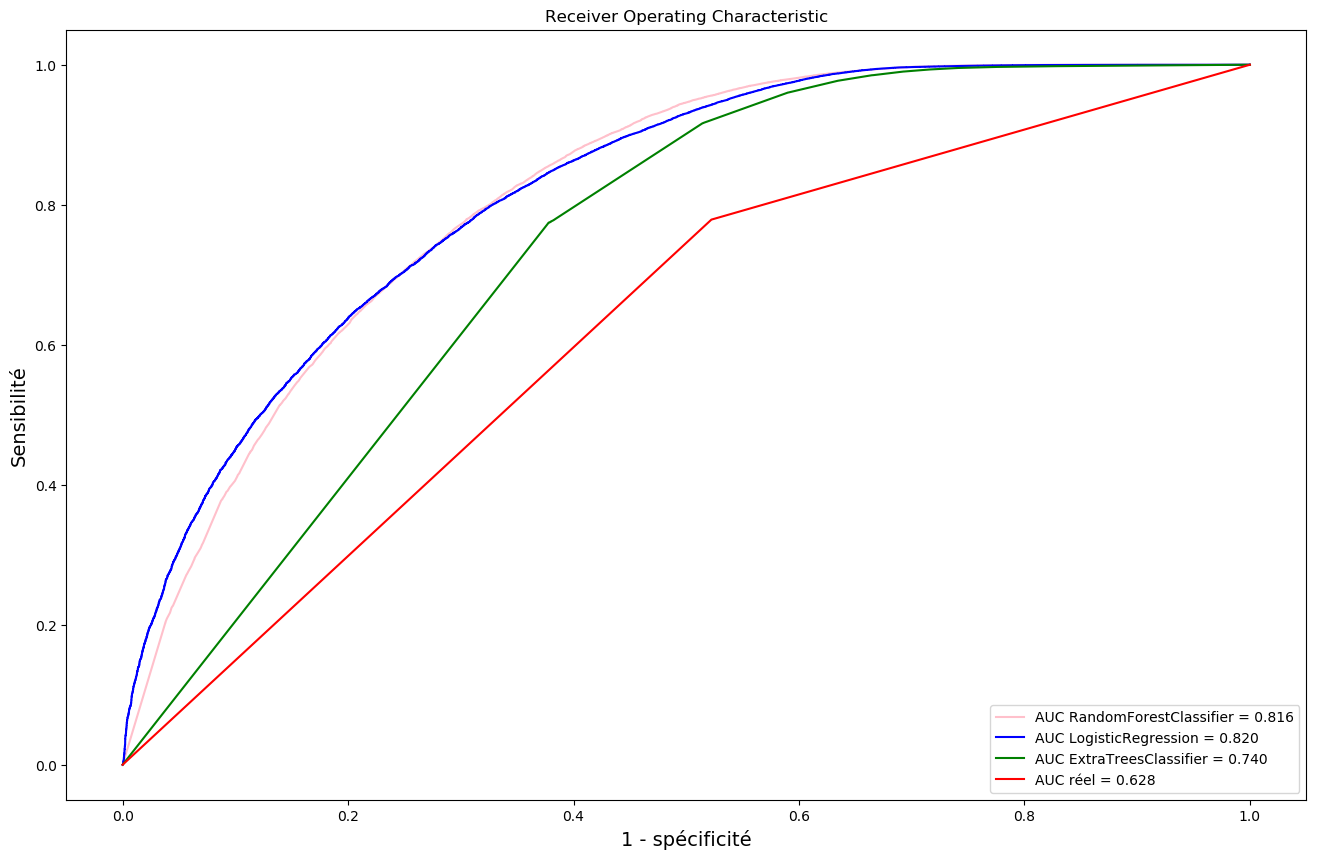

In [13]:
fpr = []
tpr = []
labels = []
rocs = []
# Méthode naive par la classe la plus fréquente pour comparer
#RunModel(dummy.DummyClassifier(strategy='most_frequent'), 'Méthode naive')
#RunModel(GaussianNB(), 'GaussianNB') Pas performant
#RunModel(KNeighborsClassifier(), 'KNeighborsClassifier') Trop long
#gbModel = RunModel(GradientBoostingClassifier(), 'GradientBoostingClassifier')
bestModel = RunModel(RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3), 'RandomForestClassifier')
lrModel = RunModel(LogisticRegression(), 'LogisticRegression')
etModel = RunModel(ExtraTreesClassifier(), 'ExtraTreesClassifier')
addReel(y_test, y_pred_actuelle)
displayROC()

procolMoins1_      0.075717
encoursMoins1      0.075304
ii_AGE             0.048804
indiScoreMoins1    0.048699
procolMoins1_R     0.039317
jg_NBDF            0.037919
encoursMoins2      0.034371
indiScoreMoins2    0.032372
procolMoins2_      0.023837
indiScoreMoins3    0.022747
procolMoins3_      0.021404
procolMoins2_R     0.020587
ii_CAPITAL         0.016668
encoursMoins3      0.016606
procolMoins1_P     0.015739
dtype: float64


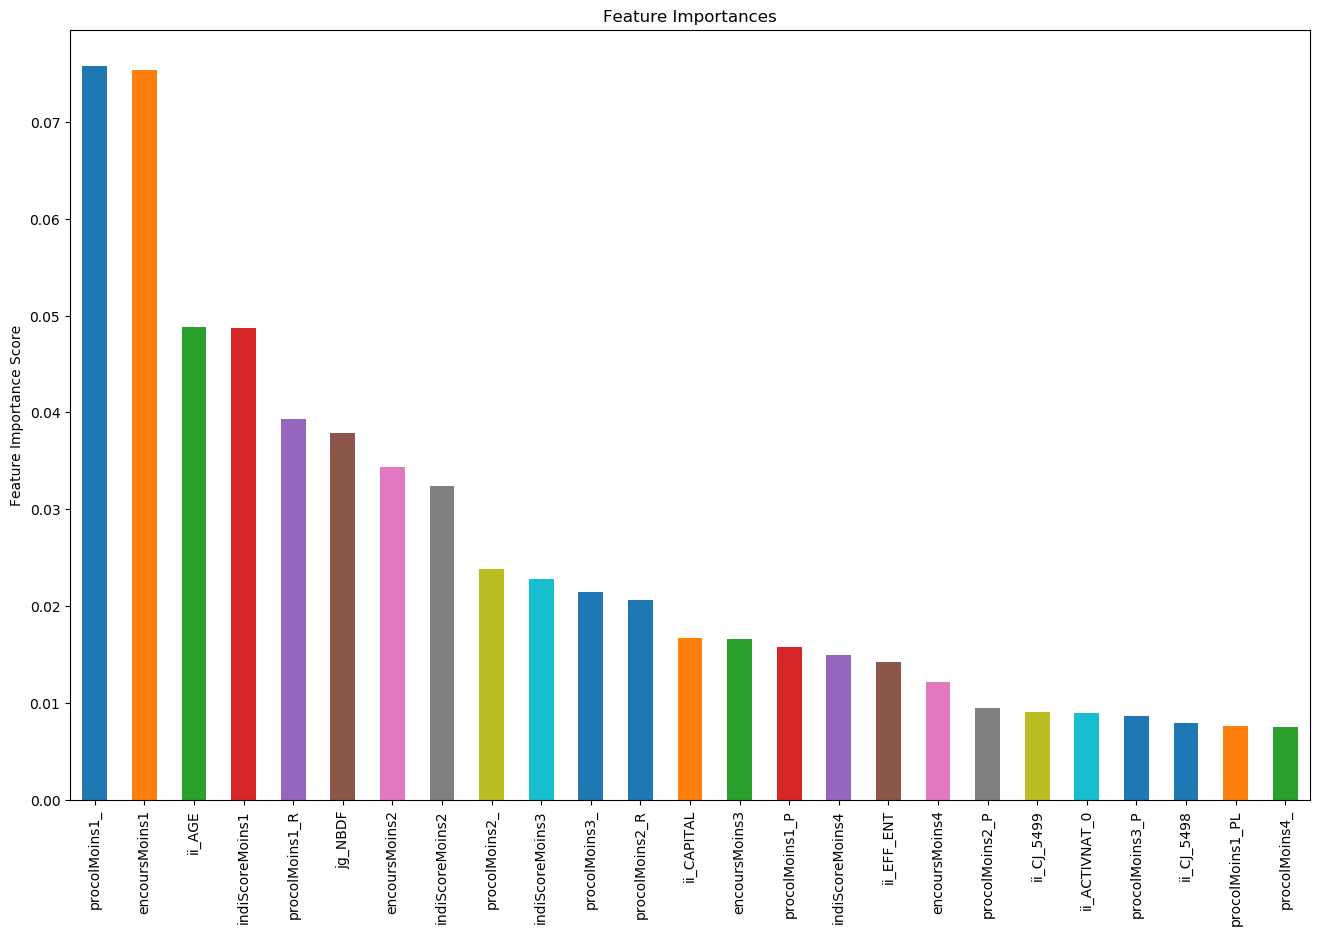

In [14]:
# Random forest
# Pas compatible avec la réduction de dimension
if not CT_REDUC:
    predictors = [x for x in x_train.columns]
    feat_imp = pd.Series(bestModel.feature_importances_, predictors).sort_values(ascending=False)
    print(feat_imp[:15])
    plt.figure(figsize=(16, 10))
    feat_imp[:25].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

encoursMoins1      0.084212
ii_AGE             0.070142
procolMoins1_      0.065280
indiScoreMoins1    0.061394
indiScoreMoins2    0.038350
encoursMoins2      0.037386
jg_NBDF            0.036543
procolMoins1_R     0.034839
procolMoins3_      0.030919
procolMoins2_R     0.026474
indiScoreMoins3    0.020315
procolMoins1_P     0.019911
ii_CAPITAL         0.019355
indiScoreMoins4    0.016187
encoursMoins3      0.015156
dtype: float64


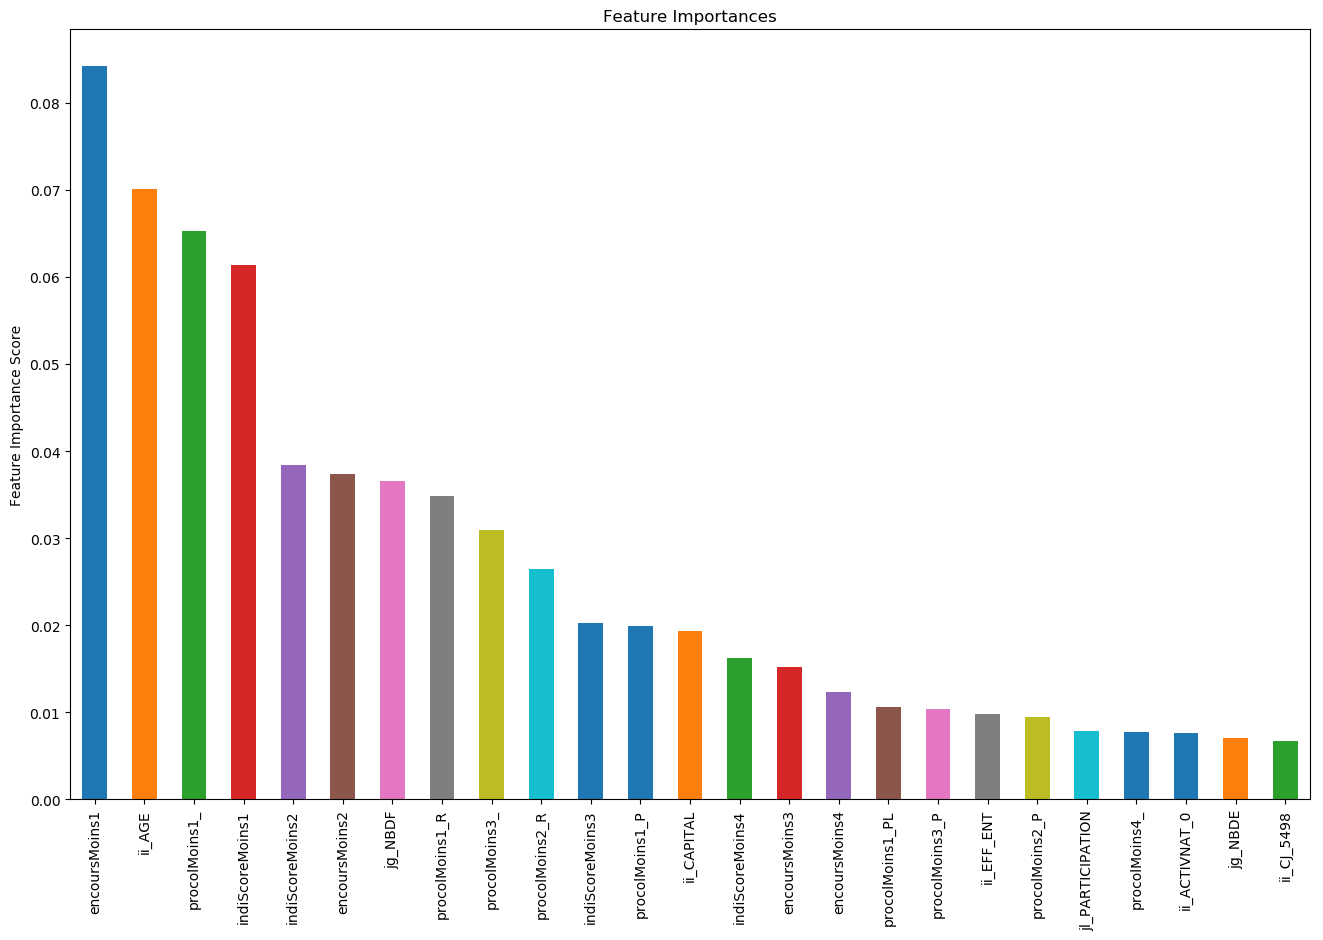

In [15]:
# Extra tree
# Pas compatible avec la réduction de dimension
if not CT_REDUC:
    predictors = [x for x in x_train.columns]
    feat_imp = pd.Series(etModel.feature_importances_, predictors).sort_values(ascending=False)
    print(feat_imp[:15])
    plt.figure(figsize=(16, 10))
    feat_imp[:25].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

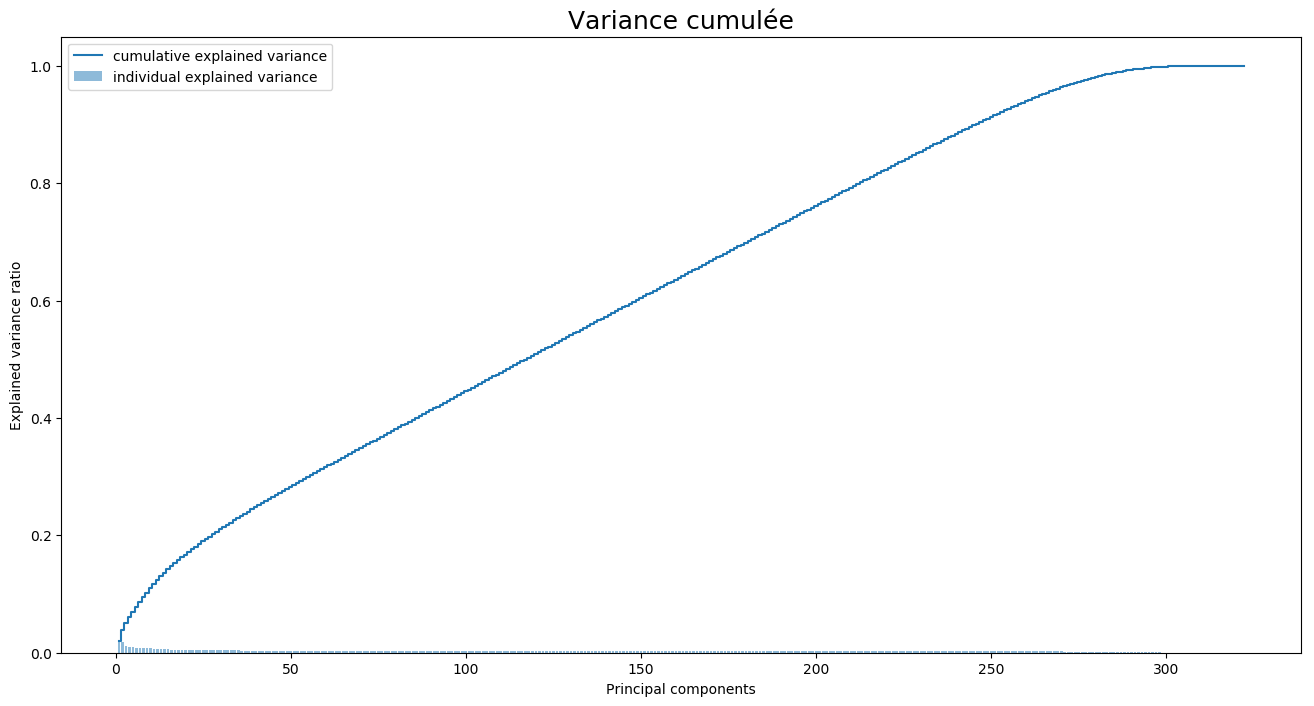

Deux composantes nous permettent d'expliquer 3.87 pourcent de la variance




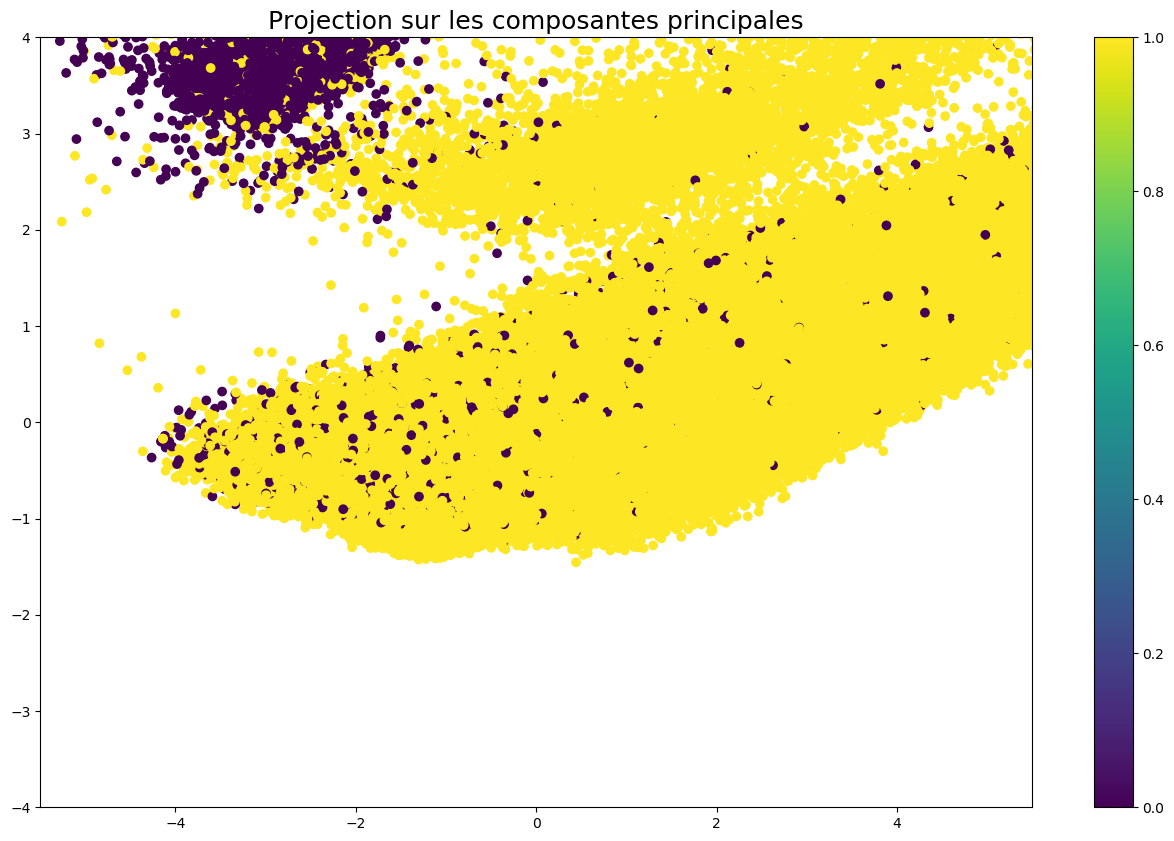

In [16]:
displayPCA(x_train, y_train)

## Optimisation du random forest

RandomForestClassifier
Matrice de confusion
	AUC = 0.783
	Spécificité = 0.253
	Precision = 0.957
	Recall = 0.997


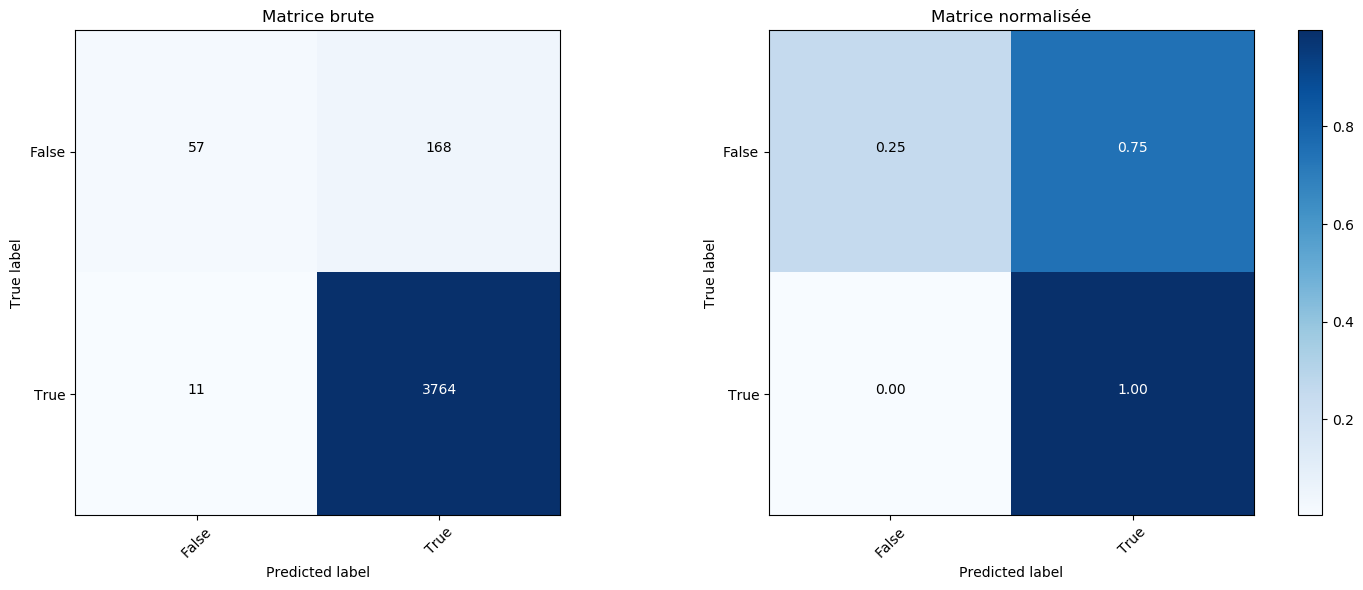

C:/Users/Mscao/Google Drive/Jupyter/GIT/Projet8/save/CJ5_RandomForestClassifier(20000, 39)783.pkl saved
	Done in 390s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
params = {
    'n_estimators': [100, 200, 500], 
    'max_depth': [None, 1, 2, 3], 
    'min_samples_split': [2, 3]
}

betterModel = RunModel(RandomForestClassifier(n_jobs=-1), 'RandomForestClassifier', params=p)
betterModel

RandomForestClassifier


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs

	AUC = 0.682
	Spécificité = 0.038
	Precision = 0.942
	Recall = 0.993


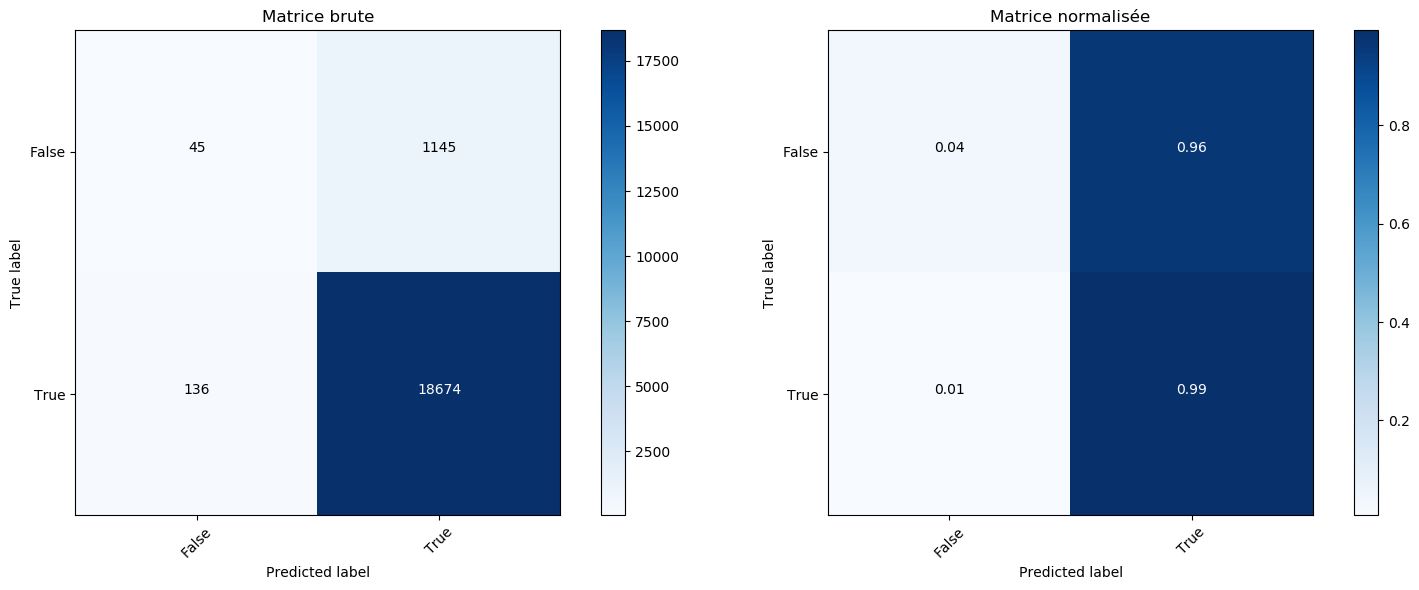

	Done in 170s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [17]:
p = {"max_features":[None,'sqrt','log2','auto']}
betterModel = RunModel(RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=3, n_jobs=-1, verbose=1), 'RandomForestClassifier', params=p)
betterModel

RandomForestClassifier


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs

	AUC = 0.712
	Spécificité = 0.000
	Precision = 0.941
	Recall = 1.000


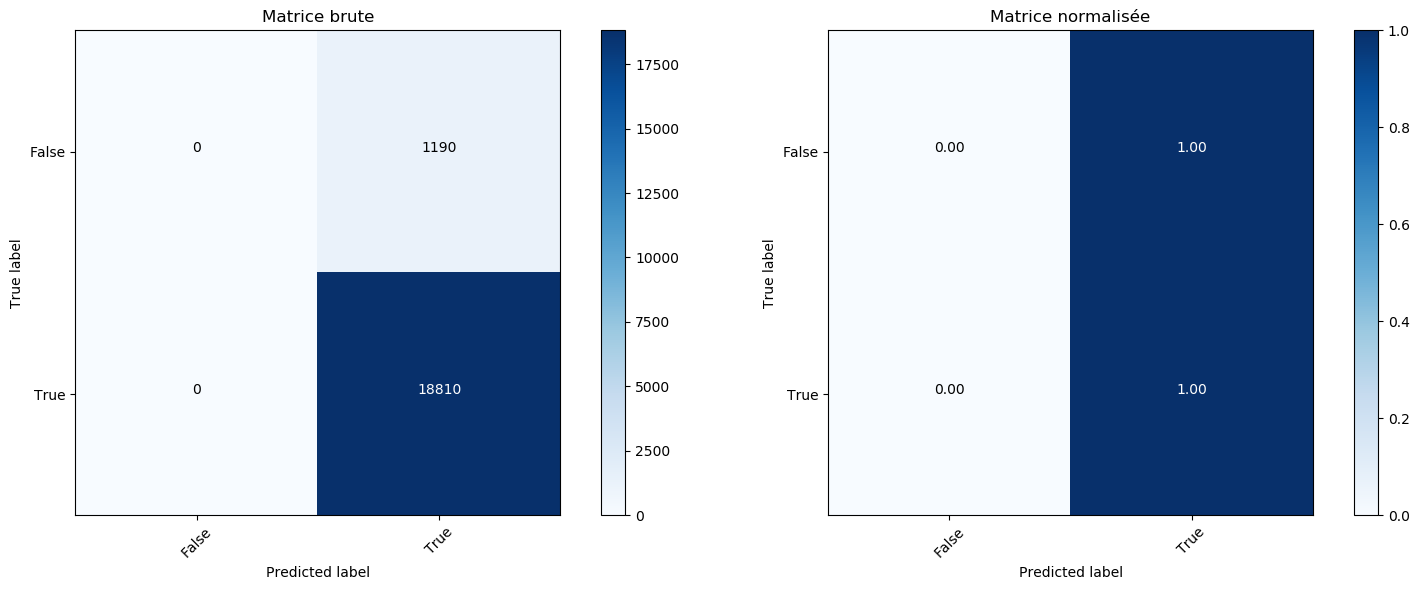

	Done in 84s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=2,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [21]:
p = {"max_leaf_nodes":[None, 2, 3, 4]}
betterModel = RunModel(RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3, max_features='log2', 
                    verbose=1, n_jobs=-1), 'RandomForestClassifier', params=p)
betterModel

RandomForestClassifier


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   33.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   37.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tas

	AUC = 0.696
	Spécificité = 0.034
	Precision = 0.942
	Recall = 0.993


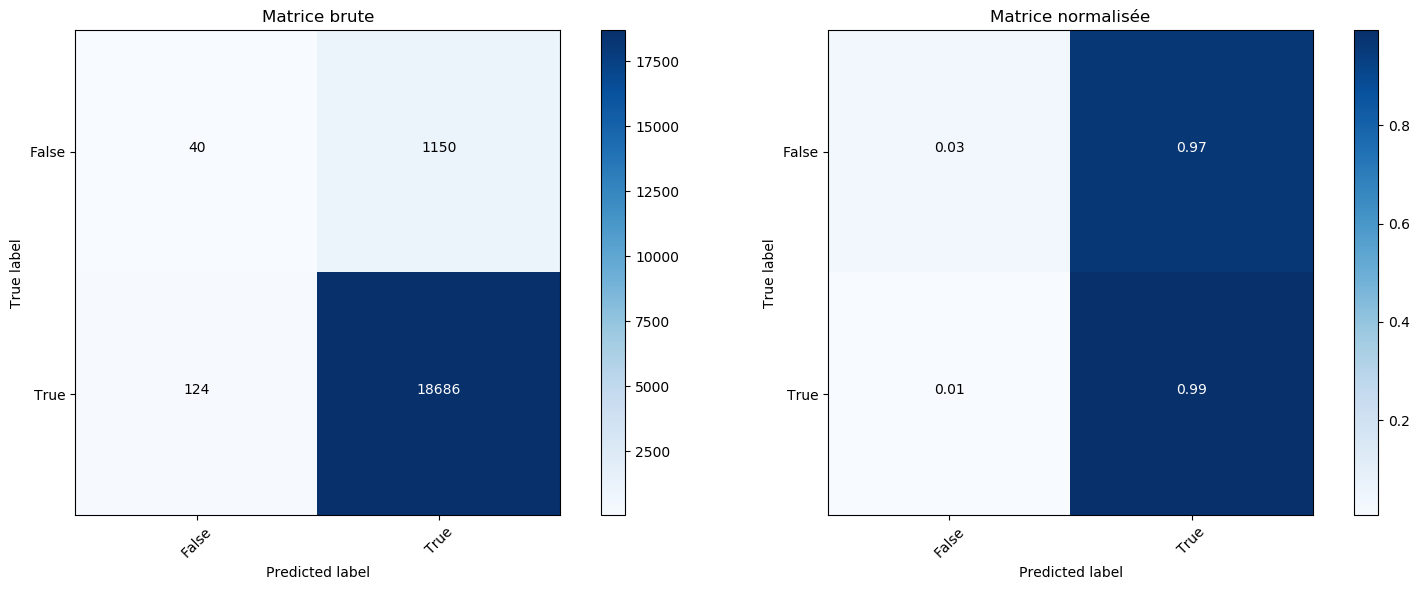

	Done in 492s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [23]:
p = {'n_estimators': [100, 200, 300, 400]}

betterModel = RunModel(RandomForestClassifier(max_depth=None, min_samples_split=3, max_features='log2', 
                    verbose=1, n_jobs=-1), 'RandomForestClassifier', params=p)
betterModel